In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats
from statannot import add_stat_annotation

from pltconfig import *

In [2]:
# Load precomputed flux inferences (from data) - see 00_LCMS_calcs notebook
flux_inference_df = pd.read_csv('data/LCMS/062220_flux_inferrence.csv')
flux_inference_df['pct_12co2_inferred'] = flux_inference_df.f12co2_inferred*100
flux_inference_df['ser_pct12c'] = flux_inference_df.ser_f12c*100

# Load precomputed flux predictions via pFBA - see 01_FBA_rubisco_flux_prediction notebook
flux_prediction_df = pd.read_csv('data/FBA/ccmb1_fluxes.csv')
rub_pct_range = (flux_prediction_df.rub_pct_3pg_prod.min(), flux_prediction_df.rub_pct_3pg_prod.max())

In [3]:
# Load the 12C labeling data for supplementary figures. Convert to percentage for plotting
f12c_label_df = pd.read_csv('data/LCMS/062220_f12c_inferred.csv', index_col=0)
num_cols = f12c_label_df.columns[:-2]
pct12c_label_df = f12c_label_df.copy()
pct12c_label_df[num_cols] *= 100

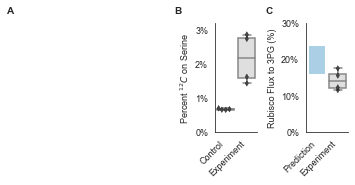

In [4]:
# Maintext figure shows the enrichment on serine and the inferred rubisco flux fractions. 
fig = plt.figure(figsize=(4, 2.5))

gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[2, 1, 1])

# A is a diagram - just leaving space. 
ax0 = fig.add_subplot(gs[0, 0])
plt.sca(ax0)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
sns.despine(bottom=True, left=True)

# B - plot %12C on serine
ax1 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[1], showfliers=False)
sns.swarmplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[-2], marker='d', 
              size=4, edgecolor='k', linewidth=0.3)

yticks = np.arange(0, 4.1, 1)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],[ 'Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax1.set_ylabel('Percent $^{12}C$ on Serine', fontsize=9)
ax1.set_xlabel('')
ax1.set_ylim((0, 3.2))
sns.despine(ax=ax1)

# C - Estimated flux through rubisco as compared to FBA predictions
ax2 = fig.add_subplot(gs[0, 2])

inferred_rub_flux = (flux_inference_df[flux_inference_df.sample_name == 'CCMB1_bioreactor'].rel_rubisco_3PG_flux*100).values.tolist()
n_exps = len(inferred_rub_flux)

width = 0.8
xy = (-width/2, rub_pct_range[0])
height = rub_pct_range[1] - rub_pct_range[0]
fba_rect = plt.Rectangle(xy, width, height, facecolor=blues[2])
ax2.add_patch(fba_rect)

sns.boxplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[1])
sns.swarmplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[-2], marker='d', 
              size=4, edgecolor='k', linewidth=0.3)

yticks = np.arange(0, 41, 10)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],['Prediction', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax2.set_ylabel('Rubisco Flux to 3PG (%)', fontsize=9)
ax2.set_xlabel('')
ax2.set_ylim(0, 30)
ax2.set_xlim(-0.5, 1.5)
sns.despine(ax=ax2)

plt.tight_layout(h_pad=2)
axs = [ax0, ax1, ax2]
panel_labels = 'ABC'
for i, ax in enumerate(axs):
    ax.text(-0.8, 1.15, panel_labels[i], transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='right')

plt.savefig('fig6/fig6.png', dpi=600, bbox_inches='tight')
plt.show()

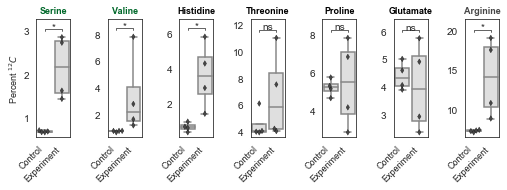

In [5]:
# Figure 6 supplement 1 - LCMS data for each amino acid measured.
# Shows that there are significant differences for amino acids where carboxylations are involved in their biosynthesis,
# either due to rubisco (ser, val) due to or carboxyphosphate incorporation into arginine.

plot_order = ['ser', 'val', 'his', 'thr', 'pro', 'glu', 'arg']
aa_names = {'ser': 'Serine',
            'val': 'Valine',
            'his': 'Histidine',
            'thr': 'Threonine',
            'pro': 'Proline',
            'glu': 'Glutamate',
            'arg': 'Arginine'}
colors = {'ser': greens[-1],
          'val': greens[-1],
          'his': 'k',
          'thr': 'k',
          'pro': 'k',
          'glu': 'k',
          'arg': greys[-2]}
n = len(plot_order)

fig = plt.figure(figsize=(7.25, 2.75))
gs = fig.add_gridspec(1, len(plot_order))
lr_order = ['CAfree_bioreactor', 'CCMB1_bioreactor']
stats_pairs = [('CAfree_bioreactor', 'CCMB1_bioreactor')]

for i, aa_col in enumerate(plot_order):
    my_ax = plt.subplot(gs[0, i])
    sns.boxplot(data=pct12c_label_df, x='sample_name', y=aa_col, order=lr_order,
                ax=my_ax, color=greys[1], showfliers=False)
    sns.swarmplot(data=pct12c_label_df, x='sample_name', y=aa_col, order=lr_order,
                  ax=my_ax, color=greys[-2], 
                  marker='d', size=4, edgecolor='k', linewidth=0.3)

    test_results = add_stat_annotation(my_ax, data=pct12c_label_df,
                                       x='sample_name', y=aa_col,
                                       order=lr_order,
                                       box_pairs=stats_pairs,
                                       test='Mann-Whitney', 
                                       text_format='star',
                                       text_offset=-2,
                                       line_height=0.02, 
                                       line_offset=0.08,
                                       linewidth=0.75,
                                       loc='inside',
                                       verbose=0)
    
    plt.xticks([0, 1],[ 'Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
    my_ax.set_title(aa_names[aa_col], color=colors[aa_col], fontsize=9, weight='bold')

    my_ax.set_xlabel('')
    ylabel = 'Percent $^{12}C$'
    if i > 0: ylabel = ''
    my_ax.set_ylabel(ylabel, fontsize=9)

plt.tight_layout()
plt.savefig('fig6/fig6S1.png', dpi=300)
plt.show()

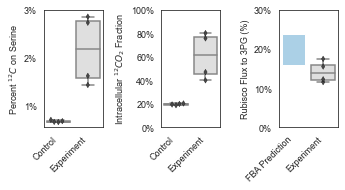

In [6]:
# Figure 6 supplement 2 - a more detailed version of the main text figure 6.
# Plots information used to make the flux inference calculation. 
fig = plt.figure(figsize=(7.25, 2.75))
gs = fig.add_gridspec(1, 4, width_ratios=[2.5, 1, 1, 1])

# plot %12C on serine
ax0 = plt.subplot(gs[0, 1])
sns.boxplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax0, color=greys[1], showfliers=False)
sns.swarmplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax0, color=greys[-2], 
              marker='d', size=4, edgecolor='k', linewidth=0.3)

yticks = np.arange(1, 3.1, 1)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],[ 'Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax0.set_ylabel('Percent $^{12}C$ on Serine', fontsize=9)
ax0.set_xlabel('')

# plot inferred 12Ci fraction.
ax1 = plt.subplot(gs[0, 2])
sns.boxplot(data=flux_inference_df, x='sample_name', y='pct_12co2_inferred', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[1], showfliers=False)
sns.swarmplot(data=flux_inference_df, x='sample_name', y='pct_12co2_inferred', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[-2], 
              marker='d', size=4, edgecolor='k', linewidth=0.3)

yticks = np.arange(0, 101, 20)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1], ['Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax1.set_xlabel('')
ax1.set_ylabel('Intracellular $^{12}CO_2$ Fraction', fontsize=9)


# Estimated flux through rubisco as compared to FBA predictions
ax2 = plt.subplot(gs[0, 3])

inferred_rub_flux = (flux_inference_df[flux_inference_df.sample_name == 'CCMB1_bioreactor'].rel_rubisco_3PG_flux*100).values.tolist()
n_exps = len(inferred_rub_flux)

# TODO - actually use prediction here.
width = 0.8
xy = (-width/2, rub_pct_range[0])
height = rub_pct_range[1] - rub_pct_range[0]
fba_rect = plt.Rectangle(xy, width, height, facecolor=blues[2])
ax2.add_patch(fba_rect)

sns.boxplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[1], showfliers=False)
sns.swarmplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[-2],
              marker='d', size=4, edgecolor='k', linewidth=0.3)

#plt.scatter([1]*n_exps, inferred_rub_flux, marker='d', s=12, color=greys[-2])
#sns.swarmplot(x=[1]*4, y=inferred_rub_flux, ax=ax2, color=greys[-2], marker='d')

yticks = np.arange(0, 31, 10)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],['FBA Prediction', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax2.set_ylabel('Rubisco Flux to 3PG (%)', fontsize=9)
ax2.set_xlabel('')
ax2.set_ylim(0, 30)
ax2.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.savefig('fig6/fig6S2.png', dpi=300)
plt.show()

In [7]:
# Print the mean inferred rubisco flux for figure captions
exps = flux_inference_df[flux_inference_df.sample_name == 'CCMB1_bioreactor']
mean_exp = exps.rel_rubisco_3PG_flux.mean() * 100
std_exp = exps.rel_rubisco_3PG_flux.std() * 100
print('Mean rubisco flux fraction %.1f%% +/- %.1f%%' % (mean_exp, std_exp))

Mean rubisco flux fraction 14.2% +/- 2.8%
